# Error rate on level/formula length

In [22]:
from matplotlib import pyplot as plt
import numpy as np
import random

In [23]:
import sys 
sys.path.insert(0,'..')
import neurosat_policy
neurosat_policy.VARIABLE_NUM = 50

In [24]:
from cnf_dataset import clauses_to_matrix
from dpll_new import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf_new import get_random_kcnf, CNF, get_sats_SR, get_pos_SR
from tqdm import tqdm
from collections import Counter

In [25]:
LIMIT_RUNS = 1000

In [26]:
def shorten_cnf(cnf: CNF):
    for c in cnf.clauses:
        if len(c) == 1:
            # print("Chosen lone clause", c[0])
            return shorten_cnf(cnf.set_var(c[0]))
    all_literals = set(x
                       for clause in cnf.clauses
                       for x in clause)
    for v in cnf.vars:
        if v in all_literals and (-v) not in all_literals:
            # print("Chosen lone literal", v)
            return shorten_cnf(cnf.set_var(v))
        if (-v) in all_literals and v not in all_literals:
            # print("Chosen lone literal", -v)
            return shorten_cnf(cnf.set_var(-v))
    return cnf

class NormalizedDPLL(DPLL):
    def run(self, cnf: CNF):
        assert isinstance(cnf, CNF)
        self.number_of_runs += 1
        if self.number_of_runs > LIMIT_RUNS:
            return None

        cnf = shorten_cnf(cnf)
        if cnf.is_true():
            return []
        elif cnf.is_false():
            return None

        sug_var = self.suggest(cnf)
        sug_cnf = cnf.set_var(sug_var)

        sug_res = self.run(sug_cnf)
        if sug_res is not None:
            return [sug_var] + sug_res

        not_sug_cnf = cnf.set_var(-sug_var)
        not_sug_res = self.run(not_sug_cnf)
        if not_sug_res is not None:
            self.number_of_errors += 1
            return [-sug_var] + not_sug_res
        return None

In [27]:
np.set_printoptions(precision=2, suppress=True)

In [28]:
import tensorflow as tf
import os

BATCH_SIZE = 1

# META_FILE = "series/18-03-24-020248/var5/models/activepolicy-18-03-24-020450/model-32000000.meta"  # perfect results
# META_FILE = "models/activepolicy-18-03-28-122105/model-10000064.meta" # ok results, no error > 80% usually, usually better than mostcommon
# META_FILE = "series/18-03-24-020248/var8/models/activepolicy-18-03-24-020450/model-6400000.meta"  # usually slightly worse than mostcommon
META_FILE = "../models/neuropol-18-09-18-002956/model-7268352.meta"
# META_FILE = os.path.expandvars("$HOME/prometheus-models/models/neuropol-restorer-18-10-09-215204-var-50-lev-30/model.ckpt-1945.meta")
# META_DIR = "/home/henryk/sat_solving/models/neuropol-restorer-18-10-09-215204-var-30-lev-30/"

# saver_hook = tf.train.CheckpointSaverHook(checkpoint_dir=META_DIR, save_steps=20)
# summary_hook = tf.train.SummarySaverHook(META_DIR)
# sess = tf.train.MonitoredSession()


sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph(META_FILE, clear_devices=True)
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint(os.path.dirname(META_FILE)))

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from ../models/neuropol-18-09-18-002956/model-7268352


In [29]:
g_inputs = graph.get_tensor_by_name("inputs:0")

In [30]:
#g_policy_probs = graph.get_tensor_by_name('policy_prob:0')
#g_sat_probs = graph.get_tensor_by_name('sat_prob:0')

In [31]:
LEVEL = 20

In [32]:
g_policy_probs_lvl = [None] + [graph.get_tensor_by_name('policy_prob_{}:0'.format(i)) for i in range(1, LEVEL+1)]
# g_sat_probs = graph.get_tensor_by_name('sat_prob_{}:0'.format(LEVEL))

In [33]:
np.set_printoptions(precision=3, suppress=True)

In [35]:
# Because we have to pass full batch

logfile = open("/tmp/log_2", "w")
#import sys
#logfile = sys.stdout

class GraphBasedDPLL(DPLL):
    def __init__(self, level):
        self.level = level
        super().__init__()
    
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs_lvl[self.level], feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        # print("Chosen neural", best_svar)
        return best_svar

In [49]:
def compute_first_errors(sats, dpll_cls, level=LEVEL):
    errors = 0
    for sat in sats:
        dpll = dpll_cls(level)
        sat = shorten_cnf(sat)
        if len(sat.vars) == 0:
            # There is no decision to be made.
            continue
        decision = dpll.suggest(sat)
        sat = sat.set_var(decision)
        if not sat.satisfiable():
            errors += 1
    return errors/len(sats)

def print_first_errors(s, n, m, light=False):
    # def get_sats_SR(sample_number, min_variable_number, clause_number, max_variable_number=None):
    global S, N, M
    S = s
    N = n # number of clauses
    M = m # number of variables
    
    MAX_TRIES = 100000
    sats = []
    
    random.seed(1)
    np.random.seed(1)
    
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_pos_SR(M, M, N)
        # if DPLL().run(sat) is not None:
        sats.append(sat)
    # print(sats[0])
    assert len(sats) == S
    # sats = get_sats_SR(S,M,N)
    # for sat in sats:
    #    print(sat)
    # assert len(sats) == S
    # print("We have generated {} formulas".format(len(sats)))
    # compute_and_print_steps(sats, DPLL)
    results = []
    for level in LEVELS:
        results.append(compute_first_errors(sats, GraphBasedDPLL, level))
    #plt.plot(LEVELS, results)
    #plt.show()
    logfile.flush()
    print(results)
    return results

LEVELS = [1, 4, 8, 12, 16, 20]


def print_all_first_errors(s, n, ms):
    data = [print_first_errors(s, n, m) for m in ms]
    columns = LEVELS
    rows = ms
    
    table = plt.table(
        cellText=data,
        rowLabels=rows,
        colLabels=columns,
        loc='top')
    print('Error rate on iteration level/SR(n)')
    plt.show()

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.01, 0.0, 0.0, 0.0, 0.0]
[0.11, 0.11, 0.04, 0.01, 0.0, 0.0]
[0.13, 0.13, 0.05, 0.03, 0.0, 0.0]
[0.17, 0.15, 0.1, 0.03, 0.02, 0.02]
[0.19, 0.09, 0.1, 0.01, 0.0, 0.0]
[0.19, 0.09, 0.09, 0.04, 0.02, 0.01]
[0.19, 0.12, 0.07, 0.03, 0.03, 0.01]
[0.17, 0.16, 0.09, 0.05, 0.05, 0.03]
[0.16, 0.1, 0.09, 0.08, 0.06, 0.06]
[0.21, 0.13, 0.09, 0.09, 0.05, 0.05]
[0.23, 0.08, 0.1, 0.11, 0.07, 0.04]
[0.22, 0.1, 0.06, 0.16, 0.08, 0.09]
[0.23, 0.1, 0.12, 0.08, 0.08, 0.08]
[0.16, 0.11, 0.09, 0.12, 0.11, 0.1]
[0.24, 0.13, 0.06, 0.12, 0.12, 0.05]
Error rate on iteration level/SR(n)


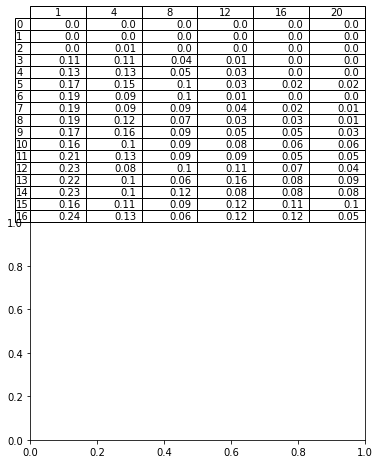

In [50]:
print_all_first_errors(100, 200, list(range(17)))